### Analysis Version 3 (a version that actually works)
##### Highlights from model, state-by-state analysis, and aggregate review.

Following the results of the updated optimisation model, this notebook aims to shed light on the outcomes. In general, it seeks to answer the question *'how can biofuels complement electrification?'* at a county level, across the set of chosen states (MN, TX, CA).

Between model v0.1 and model v0.2, the following changes were made:
- Solutions involve running linear regression in order to better understand county-level factors allowing 
- Adding at-home charging to EV viability index



In [1]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
pd.set_option('display.float_format', '{:.2f}'.format)
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = None
pd.options.display.max_rows = None
%matplotlib inline

In [2]:
selected_states = ['CA','TX','MN']
vdf = pd.read_csv('optimisation_data/visual_df.csv')
del vdf['Unnamed: 0']

In [3]:
vdf['annual_ghg_emissions'].mean()

517388011125.6396

In [4]:
ca_vdf = vdf[vdf['State']=='CA']
tx_vdf = vdf[vdf['State']=='TX']
mn_vdf = vdf[vdf['State']=='MN']
a = pd.Series(vdf.mean(), name='overall_mean')
b = pd.Series(ca_vdf.mean(), name='mn_mean')
c = pd.Series(tx_vdf.mean(), name='tx_mean')
d = pd.Series(mn_vdf.mean(), name='ca_mean')
pd.DataFrame([a,b,c,d]).T

overall_mean          mn_mean         tx_mean  \
annual_ghg_emissions  517388011125.64 1504381095330.31 343739212312.52   
annual_operating_cost     44189324.17     168284900.52     20111550.64   
total_annual_cost        949293264.78    3100346634.16    595476225.86   
annual_fuel_use           22760067.37      71845909.70     13855704.69   
total_vehicle_count         154795.45        507595.84        98121.35   
vehicle_split_BEV           120320.63        434534.34        69873.40   
vehicle_split_FFV            11526.01         33241.04         6622.21   
vehicle_split_SIDI           22948.81         39820.47        21625.74   
vehicle_pc_BEV                  33.52            65.47           27.78   
vehicle_pc_FFV                   6.80             1.98            2.39   
vehicle_pc_SIDI                 59.68            32.56           69.84   

                              ca_mean  
annual_ghg_emissions  366367275661.98  
annual_operating_cost     31754968.38  
total_annual_cost        548240764.33  
annual_fuel_use           16032817.55  
total_vehicle_count          85057.48  
vehicle_split_BEV            58127.53  
vehicle_split_FFV            11366.14  
vehicle_split_SIDI           15563.81  
vehicle_pc_BEV                  28.97  
vehicle_pc_FFV                  22.90  
vehicle_pc_SIDI                 48.13

In [5]:
evi = pd.read_csv('efuels_vi.csv')
del evi['Unnamed: 0']
evi.columns

Index(['GEO_ID', 'STATE', 'COUNTY', 'NAME', 'LSAD', 'CENSUSAREA', 'geometry',
       'electric fuel station', 'efuels_area'],
      dtype='object')

In [6]:
evi.NAME = evi.NAME.str.replace('_',' ')
evi = evi[['NAME','efuels_area','CENSUSAREA']]
vdf = vdf.merge(evi, left_on='County',right_on='NAME')
vdf.rename(columns={'CENSUSAREA':'census_area'}, inplace=True)
vdf.drop('NAME', axis=1,inplace=True)

In [7]:
vdf.dtypes

County                    object
annual_ghg_emissions     float64
annual_operating_cost    float64
total_annual_cost        float64
annual_fuel_use          float64
total_vehicle_count      float64
vehicle_split_BEV        float64
vehicle_split_FFV        float64
vehicle_split_SIDI       float64
vehicle_pc_BEV           float64
vehicle_pc_FFV           float64
vehicle_pc_SIDI          float64
State                     object
efuels_area              float64
census_area              float64
dtype: object

In [8]:
ru = pd.read_csv('preprocessed_data/rural_urban.csv')
del ru['Note']
ru = ru[ru.State.isin(selected_states)]
ru.rename(columns = {'2015 Geography Name':'County','2010 Census \nPercent Rural' : 'pct_rural',
                    '2010 Census Total Population':'census_totpop', '2010 Census Rural Population':'census_rurpop',
                    '2010 Census Urban Population':'census_urbpop'},inplace=True)

ru.County = ru.County.str.replace(' County, Texas','')
ru.County = ru.County.str.replace(' County, California','')
ru.County = ru.County.str.replace(' County, Minnesota','')

In [9]:
#cleaning up the document here to ensure that we have the right names
repeated_list = ['Orange','Cass','Lake','Trinity','Houston','Polk','Brown','Clay','Jackson','Washington','Martin']
ru.loc[ru['County'].isin(repeated_list), 'County'] = ru['County'] + ' ' + ru['State']
vdf = vdf.merge(ru)
#checking if the sets are the same
misfits = set(ru.County).symmetric_difference(set(vdf.County))
len(misfits)

0

In [10]:
vdf['census_totpop'] = vdf['census_totpop'].apply(lambda x: x.replace(',','')).astype(int)
vdf['census_urbpop'] = vdf['census_urbpop'].apply(lambda x: x.replace(',','')).astype(int)
vdf['census_rurpop'] = vdf['census_rurpop'].apply(lambda x: x.replace(',','')).astype(int)
vdf['pop_density'] =vdf['census_totpop']/vdf['census_area']
trunc = lambda x: math.trunc(1000 * x) / 1000
vdf['census_area'] = vdf['census_area'].apply(trunc)

vdf.loc[vdf['pop_density'] >= 750, 'county_class'] = 'urban'
vdf.loc[vdf['pop_density'] <= 750, 'county_class'] = 'suburban'
vdf.loc[vdf['pct_rural'] >= 50, 'county_class'] = 'rural'

In [11]:
vdf.loc[vdf['county_class'] == 'suburban','efuels_area'] = vdf['efuels_area']+40
vdf.loc[vdf['county_class'] == 'urban','efuels_area'] = vdf['efuels_area']+25

vdf['efuels_area'] = vdf['efuels_area'].apply(lambda x: 100 if x >= 100 else x)
vdf['efuels_area'].describe()

count   399.00
mean     33.51
std      32.37
min       0.00
25%       0.00
50%      36.77
75%      55.62
max     100.00
Name: efuels_area, dtype: float64

In [12]:
vdf['vehicle_pc_SIDI'].mean()

59.684210526315816

In [13]:
vdf['census_rurpop'].corr(vdf['efuels_area'])

0.41042060639905903

In [14]:
vdf['efuels_area'].corr(vdf['census_rurpop'])

0.410420606399059

In [15]:
vdf.sort_values(by='pop_density',ascending=False).head()[['County','census_area','efuels_area','census_totpop','census_urbpop','census_rurpop','pct_rural','pop_density']]

County  census_area  efuels_area  census_totpop  census_urbpop  \
37   San Francisco        46.87       100.00         805235         805235   
29       Orange CA       790.57       100.00        3010232        3005917   
119         Ramsey       152.21       100.00         508640         507688   
201         Dallas       871.28       100.00        2368139        2351839   
18     Los Angeles      4057.88        87.97        9818605        9759181   

     census_rurpop  pct_rural  pop_density  
37               0       0.00     17179.08  
29            4315       0.10      3807.68  
119            952       0.20      3341.66  
201          16300       0.70      2718.00  
18           59424       0.60      2419.64

In [16]:
from sklearn.linear_model import LinearRegression
X = vdf['efuels_area'].values.reshape(-1, 1)  # values converts it into a numpy array
y = vdf['pop_density'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column

In [17]:
X.mean()

33.51434334951582

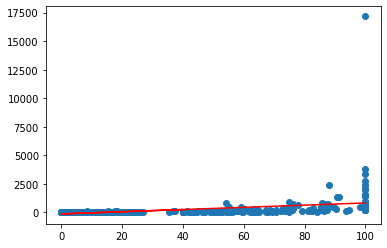

In [18]:
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, y)  # perform linear regression
y_pred = linear_regressor.predict(X)  # make predictions
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.show()

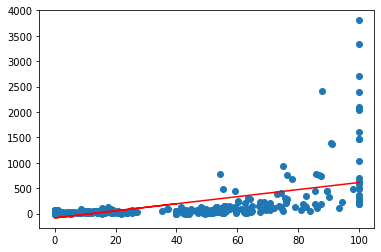

In [19]:
X_new = vdf[vdf.County != 'San Francisco']['efuels_area'].values.reshape(-1,1)
y_new = vdf[vdf.County != 'San Francisco']['pop_density'].values.reshape(-1,1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X_new, y_new)  # perform linear regression
y_newpred = linear_regressor.predict(X_new)  # make predictions
plt.scatter(X_new, y_new)
plt.plot(X_new, y_newpred, color='red')
plt.show()

#### Overall results:

In [20]:
vdf[['State','vehicle_pc_BEV','vehicle_pc_FFV','vehicle_pc_SIDI','efuels_area']].groupby(by='State').mean()

vehicle_pc_BEV  vehicle_pc_FFV  vehicle_pc_SIDI  efuels_area
State                                                              
CA              65.47            1.98            32.56        65.46
MN              28.97           22.90            48.13        28.97
TX              27.78            2.39            69.84        27.78

#### Real Analysis: California

In [21]:
# vdf[vdf['State']=='CA'].sort_values(by='efuels_area',ascending=True).head()
# vdf[(vdf['State']=='TX') & (vdf['vehicle_pc_FFV']>vdf['vehicle_pc_BEV'])].sort_values(by='vehicle_pc_FFV',ascending=False)
vdf[(vdf['State']=='MN') & (vdf['vehicle_pc_FFV']>0)].sort_values(by='vehicle_pc_FFV',ascending=False).head(10)

County  annual_ghg_emissions  annual_operating_cost  \
138           Waseca       118811080000.00            12959585.50   
100           McLeod       179260932000.00            23210085.70   
74        Cottonwood        60027191000.00             7994397.30   
144  Yellow Medicine        53904179100.00             7100187.86   
70           Chisago       262738283000.00            29027294.60   
97          Le Sueur       142842975000.00            17362337.30   
89        Jackson MN        51676333000.00             7094753.80   
122         Renville        83133503000.00            10104880.40   
121          Redwood        87452795000.00            10409496.80   
127            Scott       656116520000.00            71983409.00   

     total_annual_cost  annual_fuel_use  total_vehicle_count  \
138       187710128.00       8960031.00             26698.00   
100       352516360.00      15709924.20             51135.00   
74        114724579.00       5434810.40             16306.00   
144       102226657.20       4792604.15             14563.00   
70        499582700.00      18584589.00             75183.00   
97        264758822.00      11338910.00             38651.00   
89        100845299.00       4739442.50             14323.00   
122       151224580.00       6587460.35             21946.00   
121       154731846.00       6784123.84             22405.00   
127      1194775020.00      43828183.00            181275.00   

     vehicle_split_BEV  vehicle_split_FFV  vehicle_split_SIDI  vehicle_pc_BEV  \
138               0.00           18181.09             8516.91            0.00   
100            7791.25           33559.10             9784.65           15.20   
74                0.00           10135.02             6170.98            0.00   
144             281.56            8778.78             5502.66            1.90   
70            31120.72           44062.29                0.00           41.40   
97             8074.76           21699.13             8877.11           20.90   
89                0.00            8014.81             6308.19            0.00   
122            3648.81           11824.83             6472.37           16.60   
121            3362.48           11907.55             7134.97           15.00   
127           92035.27           89239.73                0.00           50.80   

     vehicle_pc_FFV  vehicle_pc_SIDI State  efuels_area  census_area  \
138           68.10            31.90    MN         0.00       423.36   
100           65.60            19.10    MN        68.09       491.47   
74            62.20            37.80    MN         0.00       638.61   
144           60.30            37.80    MN         1.93       759.10   
70            58.60             0.00    MN        41.39       414.86   
97            56.10            23.00    MN        20.89       448.76   
89            56.00            44.00    MN         0.00       702.98   
122           53.90            29.50    MN        16.63       982.91   
121           53.10            31.80    MN        15.01       878.57   
127           49.20             0.00    MN       100.00       356.48   

     census_totpop  census_urbpop  census_rurpop  pct_rural  pop_density  \
138          19136           9537           9599      50.20        45.20   
100          36651          19588          17063      46.60        74.57   
74           11687           4409           7278      62.30        18.30   
144          10438           2002           8436      80.80        13.75   
70           53887          23932          29955      55.60       129.89   
97           27703          10483          17220      62.20        61.73   
89           10266           3169           7097      69.10        14.60   
122          15730              0          15730     100.00        16.00   
121          16059           4958          11101      69.10        18.28   
127         129928         107529          22399      17.20       364.48   

    county_class  
138     

In [22]:
# vdf[(vdf['State']=='TX')].sort_values(by='annual_ghg_emissions',ascending=False).head(30)
# vdf[(vdf['State']=='CA')].sort_values(by='total_vehicle_count',ascending=False)
vdf.shape

(399, 21)

In [23]:
vdf[(vdf['State']=='TX') & (vdf['vehicle_pc_BEV']==0) & (vdf['vehicle_pc_FFV']>0)].sort_values(by='vehicle_pc_FFV',ascending=False)
# vdf[(vdf['State']=='CA') & (vdf['vehicle_pc_BEV']>0)].sort_values(by='vehicle_pc_FFV',ascending=False).mean()
# vdf[(vdf['State']=='TX') & (vdf['County']=='Harris')].sort_values(by='vehicle_pc_FFV',ascending=False)

County  annual_ghg_emissions  annual_operating_cost  total_annual_cost  \
151  Atascosa       291744672500.00            23595841.00       355319474.00   
331   Polk TX       330729548400.00            26663853.40       398877667.00   
307    Medina       143992358200.00            27755904.87       399910818.20   

     annual_fuel_use  total_vehicle_count  vehicle_split_BEV  \
151      18171949.20             50680.00               0.00   
331      20509589.40             56866.00               0.00   
307      21203955.66             56857.00               0.00   

     vehicle_split_FFV  vehicle_split_SIDI  vehicle_pc_BEV  vehicle_pc_FFV  \
151            4936.30            45743.70            0.00            9.70   
331            4801.87            52064.13            0.00            8.40   
307             501.54            56355.46            0.00            0.90   

     vehicle_pc_SIDI State  efuels_area  census_area  census_totpop  \
151            90.30    TX         0.00      1219.54          44911   
331            91.60    TX         0.00      1057.09          45413   
307            99.10    TX         0.00      1325.36          46006   

     census_urbpop  census_rurpop  pct_rural  pop_density county_class  
151          17645          27266      60.70        36.83        rural  
331          10155          35258      77.60        42.96        rural  
307          17687          28319      61.60        34.71        rural

In [24]:
interested_counties_ca = ['San Francisco','Los Angeles','San Bernardino'] 
interested_counties_mn = ['Ramsey','Hennepin','St. Louis']
interested_counties_tx = ['Bexar','Dallas','Comal','Lubbock','Travis']

In [25]:
#global ranking (across the sample)
vdf['ghg_globalrank'] = vdf['annual_ghg_emissions'].rank(ascending=False)
vdf['popden_globalrank'] = vdf['pop_density'].rank(ascending=False)
vdf['censusarea_globalrank'] = vdf['census_area'].rank(ascending=False)

#state ranking (within state)
vdf['ghg_staterank'] = vdf.groupby('State')['annual_ghg_emissions'].rank('dense', ascending=False)
vdf['popden_staterank'] = vdf.groupby('State')['pop_density'].rank('dense', ascending=False)
vdf['censusarea_staterank'] = vdf.groupby('State')['census_area'].rank('dense', ascending=False)

In [26]:
vdf.to_feather('analysed_vdf')

In [27]:
# vdf[vdf['County']].isin(['San Francisco','Los Angeles','San Bernadino'])
vdf[vdf['County'].isin(interested_counties_ca)][['County','State','vehicle_pc_BEV','vehicle_pc_FFV','vehicle_pc_SIDI','ghg_globalrank','ghg_staterank','popden_globalrank','popden_staterank','censusarea_globalrank','censusarea_staterank']]

County State  vehicle_pc_BEV  vehicle_pc_FFV  vehicle_pc_SIDI  \
18     Los Angeles    CA           88.00           12.00             0.00   
35  San Bernardino    CA           49.90            4.30            45.90   
37   San Francisco    CA          100.00            0.00             0.00   

    ghg_globalrank  ghg_staterank  popden_globalrank  popden_staterank  \
18            1.00           1.00               5.00              3.00   
35           11.00           6.00              88.00             32.00   
37           33.00          16.00               1.00              1.00   

    censusarea_globalrank  censusarea_staterank  
18                  15.00                 11.00  
35                   1.00                  1.00  
37                 399.00                 58.00

In [28]:
vdf[vdf['County'].isin(interested_counties_mn)][['County','State','vehicle_pc_BEV','vehicle_pc_FFV','vehicle_pc_SIDI','ghg_globalrank','ghg_staterank','popden_globalrank','popden_staterank','censusarea_globalrank','censusarea_staterank']]

County State  vehicle_pc_BEV  vehicle_pc_FFV  vehicle_pc_SIDI  \
84    Hennepin    MN          100.00            0.00             0.00   
119     Ramsey    MN          100.00            0.00             0.00   
126  St. Louis    MN            2.90            3.60            93.50   

     ghg_globalrank  ghg_staterank  popden_globalrank  popden_staterank  \
84             6.00           1.00               8.00              2.00   
119           14.00           2.00               3.00              1.00   
126           35.00           6.00             184.00             38.00   

     censusarea_globalrank  censusarea_staterank  
84                  348.00                 60.00  
119                 397.00                 87.00  
126                   6.00                  1.00

In [29]:
vdf[vdf['County'].isin(interested_counties_tx)][['County','State','ghg_globalrank','ghg_staterank','popden_globalrank','popden_staterank','censusarea_globalrank','censusarea_staterank','vehicle_pc_BEV','vehicle_pc_FFV','vehicle_pc_SIDI']]

County State  ghg_globalrank  ghg_staterank  popden_globalrank  \
159    Bexar    TX           10.00           4.00              13.00   
190    Comal    TX           93.00          45.00              57.00   
201   Dallas    TX            2.00           1.00               4.00   
296  Lubbock    TX           52.00          20.00              40.00   
371   Travis    TX           31.00          11.00              15.00   

     popden_staterank  censusarea_globalrank  censusarea_staterank  \
159              4.00                  91.00                 37.00   
190             29.00                 346.00                234.00   
201              1.00                 248.00                177.00   
296             19.00                 224.00                155.00   
371              5.00                 139.00                 76.00   

     vehicle_pc_BEV  vehicle_pc_FFV  vehicle_pc_SIDI  
159           90.70            9.30             0.00  
190           81.60           18.40             0.00  
201          100.00            0.00             0.00  
296           63.70           29.40             6.90  
371          100.00            0.00             0.00

In [30]:
vdf[vdf['County']=='Comal']


County  annual_ghg_emissions  annual_operating_cost  total_annual_cost  \
190  Comal       309268895000.00            26281909.60      1044210570.00   

     annual_fuel_use  total_vehicle_count  vehicle_split_BEV  \
190      17903706.00            176579.00          144022.56   

     vehicle_split_FFV  vehicle_split_SIDI  vehicle_pc_BEV  vehicle_pc_FFV  \
190           32556.44                0.00           81.60           18.40   

     vehicle_pc_SIDI State  efuels_area  census_area  census_totpop  \
190             0.00    TX        81.56       559.48         108472   

     census_urbpop  census_rurpop  pct_rural  pop_density county_class  \
190          58417          50055      46.10       193.88     suburban   

     ghg_globalrank  popden_globalrank  censusarea_globalrank  ghg_staterank  \
190           93.00              57.00                 346.00          45.00   

     popden_staterank  censusarea_staterank  
190             29.00                234.00

In [31]:
vdf[['County','State','ghg_globalrank','ghg_staterank','vehicle_pc_BEV','vehicle_pc_FFV','vehicle_pc_SIDI']].sort_values(by=['ghg_staterank','ghg_globalrank'],ascending=True).head(15)


County State  ghg_globalrank  ghg_staterank  vehicle_pc_BEV  \
18     Los Angeles    CA            1.00           1.00           88.00   
201         Dallas    TX            2.00           1.00          100.00   
84        Hennepin    MN            6.00           1.00          100.00   
29       Orange CA    CA            3.00           2.00          100.00   
364        Tarrant    TX            4.00           2.00          100.00   
119         Ramsey    MN           14.00           2.00          100.00   
32       Riverside    CA            5.00           3.00           75.80   
245         Harris    TX            7.00           3.00          100.00   
76          Dakota    MN           18.00           3.00          100.00   
42     Santa Clara    CA            8.00           4.00           91.20   
159          Bexar    TX           10.00           4.00           90.70   
59           Anoka    MN           27.00           4.00           85.70   
36       San Diego    CA            9.00           5.00           87.70   
187         Collin    TX           15.00           5.00           75.00   
139  Washington MN    MN           29.00           5.00          100.00   

     vehicle_pc_FFV  vehicle_pc_SIDI  
18            12.00             0.00  
201            0.00             0.00  
84             0.00             0.00  
29             0.00             0.00  
364            0.00             0.00  
119            0.00             0.00  
32            16.80             7.40  
245            0.00             0.00  
76             0.00             0.00  
42             8.80             0.00  
159            9.30             0.00  
59            14.30             0.00  
36            12.30             0.00  
187           25.00             0.00  
139            0.00             0.00

In [32]:
vdf[['County','State','popden_globalrank','popden_staterank','vehicle_pc_BEV','vehicle_pc_FFV','vehicle_pc_SIDI']].sort_values(by=['popden_staterank','popden_globalrank'],ascending=True).head(20)

County State  popden_globalrank  popden_staterank  vehicle_pc_BEV  \
37   San Francisco    CA               1.00              1.00          100.00   
119         Ramsey    MN               3.00              1.00          100.00   
201         Dallas    TX               4.00              1.00          100.00   
29       Orange CA    CA               2.00              2.00          100.00   
245         Harris    TX               6.00              2.00          100.00   
84        Hennepin    MN               8.00              2.00          100.00   
18     Los Angeles    CA               5.00              3.00           88.00   
364        Tarrant    TX               7.00              3.00          100.00   
59           Anoka    MN              18.00              3.00           85.70   
0          Alameda    CA               9.00              4.00          100.00   
159          Bexar    TX              13.00              4.00           90.70   
76          Dakota    MN              22.00              4.00          100.00   
40       San Mateo    CA              10.00              5.00          100.00   
371         Travis    TX              15.00              5.00          100.00   
139  Washington MN    MN              24.00              5.00          100.00   
33      Sacramento    CA              11.00              6.00          100.00   
187         Collin    TX              16.00              6.00           75.00   
127          Scott    MN              37.00              6.00           50.80   
6     Contra Costa    CA              12.00              7.00          100.00   
215        El Paso    TX              17.00              7.00           82.10   

     vehicle_pc_FFV  vehicle_pc_SIDI  
37             0.00             0.00  
119            0.00             0.00  
201            0.00             0.00  
29             0.00             0.00  
245            0.00             0.00  
84             0.00             0.00  
18            12.00             0.00  
364            0.00             0.00  
59            14.30             0.00  
0              0.00             0.00  
159            9.30             0.00  
76             0.00             0.00  
40             0.00             0.00  
371            0.00             0.00  
139            0.00             0.00  
33             0.00             0.00  
187           25.00             0.00  
127           49.20             0.00  
6              0.00             0.00  
215            0.00            17.90

In [33]:
vdf[['County','State','censusarea_globalrank','censusarea_staterank','vehicle_pc_BEV','vehicle_pc_FFV','vehicle_pc_SIDI']].sort_values(by=['censusarea_staterank','censusarea_globalrank'],ascending=True).head(15)

County State  censusarea_globalrank  censusarea_staterank  \
35   San Bernardino    CA                   1.00                  1.00   
126       St. Louis    MN                   6.00                  1.00   
166        Brewster    TX                   7.00                  1.00   
13             Inyo    CA                   2.00                  2.00   
330           Pecos    TX                  10.00                  2.00   
93      Koochiching    MN                  27.00                  2.00   
14             Kern    CA                   3.00                  3.00   
259        Hudspeth    TX                  11.00                  3.00   
88           Itasca    MN                  32.00                  3.00   
32        Riverside    CA                   4.00                  4.00   
333        Presidio    TX                  17.00                  4.00   
61         Beltrami    MN                  35.00                  4.00   
46         Siskiyou    CA                   5.00                  5.00   
199       Culberson    TX                  18.00                  5.00   
95          Lake MN    MN                  41.00                  5.00   

     vehicle_pc_BEV  vehicle_pc_FFV  vehicle_pc_SIDI  
35            49.90            4.30            45.90  
126            2.90            3.60            93.50  
166           40.00            0.00            60.00  
13            43.40            0.00            56.60  
330           42.70            0.00            57.30  
93            40.00            0.00            60.00  
14            62.80            2.00            35.30  
259            0.50            0.00            99.50  
88             0.00            4.10            95.90  
32            75.80           16.80             7.40  
333           42.90            0.00            57.10  
61             3.40            0.00            96.60  
46             5.60            0.00            94.40  
199            3.00            0.00            97.00  
95             0.00            2.70            97.30

In [34]:
#introducing VMT
VMT = pd.read_csv('./vmt/vmt_transpose.csv')
VMT['Classification'] = VMT['Classification'].str.lower()
N = pd.read_csv('https://raw.githubusercontent.com/saif1457/biofuels/master/optimisation_data/N(r).csv')
N.county = N.county.str.replace('_',' ')

In [35]:
vdf = vdf.merge(N, left_on='County',right_on='county')
vdf.shape

(399, 30)

In [36]:
vdf.columns

Index(['County', 'annual_ghg_emissions', 'annual_operating_cost',
       'total_annual_cost', 'annual_fuel_use', 'total_vehicle_count',
       'vehicle_split_BEV', 'vehicle_split_FFV', 'vehicle_split_SIDI',
       'vehicle_pc_BEV', 'vehicle_pc_FFV', 'vehicle_pc_SIDI', 'State',
       'efuels_area', 'census_area', 'census_totpop', 'census_urbpop',
       'census_rurpop', 'pct_rural', 'pop_density', 'county_class',
       'ghg_globalrank', 'popden_globalrank', 'censusarea_globalrank',
       'ghg_staterank', 'popden_staterank', 'censusarea_staterank', 'county',
       'median_household_income_2018', 'household_income_ID'],
      dtype='object')

In [37]:
VMT.columns

Index(['household_income_ID', 'Income Class', 'state', 'Classification',
       'VMT'],
      dtype='object')

In [38]:
vdf = vdf.merge(VMT,left_on=['household_income_ID','State','county_class'],right_on=['household_income_ID','state','Classification'])
vdf.shape

(399, 34)

In [39]:
del vdf['county']
del vdf['state']

In [40]:
vdf.columns

Index(['County', 'annual_ghg_emissions', 'annual_operating_cost',
       'total_annual_cost', 'annual_fuel_use', 'total_vehicle_count',
       'vehicle_split_BEV', 'vehicle_split_FFV', 'vehicle_split_SIDI',
       'vehicle_pc_BEV', 'vehicle_pc_FFV', 'vehicle_pc_SIDI', 'State',
       'efuels_area', 'census_area', 'census_totpop', 'census_urbpop',
       'census_rurpop', 'pct_rural', 'pop_density', 'county_class',
       'ghg_globalrank', 'popden_globalrank', 'censusarea_globalrank',
       'ghg_staterank', 'popden_staterank', 'censusarea_staterank',
       'median_household_income_2018', 'household_income_ID', 'Income Class',
       'Classification', 'VMT'],
      dtype='object')

In [42]:
#cleaning up the table
vdf = vdf.rename(columns={'VMT':'annual_vmt'})
vdf = vdf[['County',
             'State',
 'annual_ghg_emissions',
 'annual_operating_cost',
 'total_annual_cost',
 'annual_fuel_use',
 'total_vehicle_count',
 'vehicle_split_BEV',
 'vehicle_split_FFV',
 'vehicle_split_SIDI',
 'vehicle_pc_BEV',
 'vehicle_pc_FFV',
 'vehicle_pc_SIDI',
 'efuels_area',
 'census_area',
 'census_totpop',
 'census_urbpop',
 'census_rurpop',
 'pct_rural',
 'pop_density',
 'county_class',
 'ghg_globalrank',
 'popden_globalrank',
 'censusarea_globalrank',
 'ghg_staterank',
 'popden_staterank',
 'censusarea_staterank',
 'median_household_income_2018',
 'household_income_ID',
 'annual_vmt']]
vdf.columns

Index(['County', 'State', 'annual_ghg_emissions', 'annual_operating_cost',
       'total_annual_cost', 'annual_fuel_use', 'total_vehicle_count',
       'vehicle_split_BEV', 'vehicle_split_FFV', 'vehicle_split_SIDI',
       'vehicle_pc_BEV', 'vehicle_pc_FFV', 'vehicle_pc_SIDI', 'efuels_area',
       'census_area', 'census_totpop', 'census_urbpop', 'census_rurpop',
       'pct_rural', 'pop_density', 'county_class', 'ghg_globalrank',
       'popden_globalrank', 'censusarea_globalrank', 'ghg_staterank',
       'popden_staterank', 'censusarea_staterank',
       'median_household_income_2018', 'household_income_ID', 'annual_vmt'],
      dtype='object')

In [43]:
vdf.to_csv('model_resultsv4.csv')

In [44]:
model = pd.read_csv('model_resultsv4.csv')
del model['Unnamed: 0']

In [45]:
import feather
e85_store = pd.read_feather('./e85_store', use_threads=True)
e85_store = e85_store[['NAME','e85_area','Station Count']]
e85_store = e85_store.rename(columns={'NAME':'County'})
e85_store = e85_store.rename(columns={'Station Count':'E85 Station Count'})
e85_store.County = e85_store.County.str.replace('_',' ')

In [46]:
model = model.merge(e85_store)

In [47]:
model[['State','vehicle_pc_BEV','vehicle_pc_FFV','vehicle_pc_SIDI','efuels_area','e85_area','annual_vmt']].groupby(by='State').mean()

vehicle_pc_BEV  vehicle_pc_FFV  vehicle_pc_SIDI  efuels_area  e85_area  \
State                                                                           
CA              65.47            1.98            32.56        65.46      6.46   
MN              28.97           22.90            48.13        28.97     20.72   
TX              27.78            2.39            69.84        27.78      3.31   

       annual_vmt  
State              
CA       10690.08  
MN       13610.84  
TX       12040.47

In [49]:
model.shape
model

County State  annual_ghg_emissions  annual_operating_cost  \
0              Alameda    CA      1783929600000.00           318966620.00   
1         Contra Costa    CA      4027894200000.00           240519220.00   
2        San Francisco    CA      1565396800000.00           119103380.00   
3            San Mateo    CA      3143350500000.00           187700110.00   
4               Alpine    CA         3585886300.00             1133274.62   
5               Amador    CA        71470663000.00            15703854.50   
6            Calaveras    CA        98361826000.00            36755748.00   
7               Lassen    CA        25027358900.00            10962502.54   
8             Mariposa    CA        43932691000.00            11913482.10   
9               Plumas    CA        25952409400.00            10058090.19   
10              Sierra    CA        10621278900.00             1645043.82   
11               Butte    CA       298096099000.00            51513684.20   
12              Colusa    CA        30335598000.00             5843898.40   
13              Fresno    CA      2085962760000.00           285510852.00   
14                Inyo    CA        81030740000.00            10938944.30   
15                Kern    CA      2042795273000.00           269293965.50   
16               Kings    CA       336253878000.00            37745906.00   
17              Madera    CA       398264805900.00            45381971.64   
18           Mendocino    CA       195548359000.00            37310460.00   
19              Merced    CA       600959287000.00            76249314.00   
20                Mono    CA        46898975000.00             5909995.90   
21            Monterey    CA       659752890000.00           115046798.00   
22              Nevada    CA       266433265000.00            24159899.10   
23           Riverside    CA      6671700970000.00           638680283.00   
24      San Bernardino    CA      4254686890000.00           785605039.00   
25         San Joaquin    CA      2383015204000.00           155934049.00   
26     San Luis Obispo    CA       943975058000.00            83620342.00   
27              Shasta    CA       338543332000.00            51199937.00   
28          Stanislaus    CA      1509320031000.00           139719974.50   
29              Sutter    CA       155871241018.00            26620344.72   
30            Tuolumne    CA       203676124000.00            26451988.00   
31                Yolo    CA       528692110000.00            33357350.00   
32           Del Norte    CA        45783428000.00             8396648.60   
33               Glenn    CA        59840793530.00             7819214.68   
34            Humboldt    CA       271428662000.00            46386536.00   
35            Imperial    CA       569520969200.00            77311980.10   
36             Lake CA    CA       253193261000.00            27145584.10   
37              Tulare    CA       950030750000.00           139557809.30   
38                Yuba    CA       117812378000.00            17962639.00   
39           El Dorado    CA       603320186000.00            43344079.50   
40                Napa    CA       202352520000.00            36180631.00   
41              Placer    CA       475530950000.00            85024933.00   
42          San Benito    CA       137792279000.00            25904270.70   
43           San Diego    CA      5121680100000.00           872938300.00   
44       Santa Barbara    CA       806205945000.00           139706889.10   
45          Santa Cruz    CA      1050714500000.00            69210035.00   
46              Solano    CA      1325514500000.00            87310969.00   
47              Sonoma    CA      1675351900000.00           127469330.00   
48             Ventura    CA      2988557665000.00           236647063.00   
49         Los Angeles    CA     13727876700000.00          2314630480.00   
50           Orange CA    CA     11018114000000.00           695177920.00   
51          

In [50]:
model[model['State']=='CA']['vehicle_pc_BEV'].mean()

65.46896551724137

In [51]:
model[model['State']=='TX']['vehicle_pc_FFV'].mean()

2.38503937007874

In [52]:
model[model['State']=='MN']['vehicle_pc_SIDI'].mean()

48.12758620689656

In [53]:
model[model['County']=='Traverse']

County State  annual_ghg_emissions  annual_operating_cost  \
64  Traverse    MN        23465278000.00             2472513.00   

    total_annual_cost  annual_fuel_use  total_vehicle_count  \
64        34964149.00       1412864.50              4964.00   

    vehicle_split_BEV  vehicle_split_FFV  vehicle_split_SIDI  vehicle_pc_BEV  \
64               0.00               0.00             4964.00            0.00   

    vehicle_pc_FFV  vehicle_pc_SIDI  efuels_area  census_area  census_totpop  \
64            0.00           100.00         0.00       573.90           3558   

    census_urbpop  census_rurpop  pct_rural  pop_density county_class  \
64              0           3558     100.00         6.20        rural   

    ghg_globalrank  popden_globalrank  censusarea_globalrank  ghg_staterank  \
64          339.00             326.00                 341.00          86.00   

    popden_staterank  censusarea_staterank median_household_income_2018  \
64             81.00                 55.00                      $49,773   

    household_income_ID  annual_vmt  e85_area  E85 Station Count  
64                    5    10517.98     13.75               2.00

In [54]:
model.efuels_area.mean()

33.514343349515805

In [55]:
model[['vehicle_pc_BEV','vehicle_pc_FFV','vehicle_pc_SIDI','efuels_area','e85_area','county_class','annual_vmt']].groupby(by='county_class').mean()
#TODO: can do by state

vehicle_pc_BEV  vehicle_pc_FFV  vehicle_pc_SIDI  efuels_area  \
county_class                                                                 
rural                   7.85            7.17            84.98         5.90   
suburban               56.53            6.32            37.15        58.67   
urban                  91.46            7.27             1.27        92.40   

              e85_area  annual_vmt  
county_class                        
rural             4.13    11955.06  
suburban          7.33    12601.42  
urban            44.51    10886.00

In [56]:
model[model['State']=='CA'][['vehicle_pc_BEV','vehicle_pc_FFV','vehicle_pc_SIDI','efuels_area','e85_area','county_class','annual_vmt']].groupby(by='county_class').mean()
#TODO: can do by state

vehicle_pc_BEV  vehicle_pc_FFV  vehicle_pc_SIDI  efuels_area  \
county_class                                                                 
rural                  14.37            0.00            85.63        14.37   
suburban               73.33            2.41            24.26        73.32   
urban                  97.40            2.60             0.00        97.40   

              e85_area  annual_vmt  
county_class                        
rural             0.00     9646.37  
suburban          2.90    10952.73  
urban            32.72    10844.79

In [57]:
model[model['State']=='MN'][['vehicle_pc_BEV','vehicle_pc_FFV','vehicle_pc_SIDI','efuels_area','e85_area','county_class','annual_vmt']].groupby(by='county_class').mean()
#TODO: can do by state

vehicle_pc_BEV  vehicle_pc_FFV  vehicle_pc_SIDI  efuels_area  \
county_class                                                                 
rural                   9.66           23.43            66.90         7.41   
suburban               60.49           23.78            15.74        64.99   
urban                  95.23            4.77             0.00        95.24   

              e85_area  annual_vmt  
county_class                        
rural            13.37    11867.92  
suburban         28.52    17516.38  
urban            85.30     9693.68

In [58]:
model[model['State']=='TX'][['vehicle_pc_BEV','vehicle_pc_FFV','vehicle_pc_SIDI','efuels_area','e85_area','county_class','annual_vmt']].groupby(by='county_class').mean()
#population percentage to better contextualise the VMT values

vehicle_pc_BEV  vehicle_pc_FFV  vehicle_pc_SIDI  efuels_area  \
county_class                                                                 
rural                   6.58            1.05            92.37         4.59   
suburban               49.51            3.23            47.26        51.81   
urban                  84.91           12.26             2.83        87.01   

              e85_area  annual_vmt  
county_class                        
rural             0.66    12177.68  
suburban          3.48    11928.76  
urban            41.40    11320.08

_____
## Solutions to "Major Comments" from 11/18


- **Why is there no electricity complement for Waseca, MN?** 
    - Waseca, MN quick stats:
        - 68.1% FFV, 0 BEV, 31.9% SIDI
    - There's no BEV infrastructure (efuels area = 0) in Waseca. Hence, there is a zero pc allocation to BEV.
- **What's the matter with Red Lake, MN and Traverse, MN?**
    - Red Lake, MN quick stats:
        - Population Density: 9.45/sqmi
        - Vehicles: 5705 vehicles
        - Emissions: 1.9x10^10 GHG
        - {24.9% FFV, 0 BEV, 75.1% SIDI}
    - Traverse, MN quick stats:
        - Population Density: 6.19/sqmi
        - Vehicles: 4964 vehicles
        - Emissions: 2.4x10^10 GHG
        - {0% FFV, 0 BEV, 100% SIDI}
    - So it turns out that despite having a higher population density and total vehicle count, Red Lake, MN has a lower emission total than Traverse, MN.
    - This can be attributed to its almost 25 pc allocation to flex fuel vehicles. Neither county has any BEV infrastructure, and both are classed as 'rural' counties in Minnesota.

Introducing VMT (Vehicle Miles Travelled) using the National Household Travel Survey (NHTS, 2017) on the habits and consumption of the American public. From this, we get the state-wide HH income VMT, which can be combined with county average HH to understand the average miles travelled in that particular county. It might be possible to get a more detailed picture than county level, but for the progress of this work, our central interest lies in understanding the overarching area trends for biofuels, and all vehicle splits in terms of mileage comes from optimised percentage applied to total mileage.

**FUELTYPE % * TOTAL MILES = MILES USING FUEL TYPE**

An obvious problem with this is that its possible for a county that despite having large BEV/FFV allocations, to have a disproportionate amount of VMT with SIDI. However, is this actually a serious concern? Most likely, optimised allocation will reflect usage and consumer behaviour with some outliers (to be expected). Also, the VMT is an explanatory variable, with little in the way of importance to outcomes. For these reasons, it makes sense to include the version outlined above.

In [59]:
# ca_vmt = pd.read_csv('./vmt/ca_vmt.csv')
# ca_vmt['Suburban'] = ca_vmt[['Second City','Suburban']].mean(axis=1)
# del ca_vmt['Second City']
# ca_vmt['Rural'] = ca_vmt[['Rural','Small Town']].mean(axis=1)
# del ca_vmt['Small Town']
# ca_vmt
# ca_vmt.to_csv('./vmt/ca_vmt_transpose.csv')

In [60]:
# tx_vmt = pd.read_csv('./vmt/tx_vmt.csv')
# tx_vmt['Suburban'] = tx_vmt[['Second City','Suburban']].mean(axis=1)
# del tx_vmt['Second City']
# tx_vmt['Rural'] = tx_vmt[['Rural','Small Town']].mean(axis=1)
# del tx_vmt['Small Town']
# tx_vmt.to_csv('./vmt/tx_vmt_transpose.csv')

In [61]:
# mn_vmt = pd.read_csv('./vmt/mn_vmt.csv')
# mn_vmt['Second City'].str.replace('.',np.NaN)

# mn_vmt['Suburban'] = mn_vmt[['Second City','Suburban']].mean(axis=1)
# del mn_vmt['Second City']
# mn_vmt['Rural'] = mn_vmt[['Rural','Small Town']].mean(axis=1)
# del mn_vmt['Small Town']
# mn_vmt

In [63]:

# model

- What is the best way to incorporate the relationship between GHG reduction, vehicle allocation and cost reduction? (not going to address this)
- Is it possible to have a state level 3D chart that shows the total VMT, Vehicle counts, and GHG emissions of each state?
- It would be helpful to see the 2017 vehicle split without the optimization so the reader can see how far the model takes us from 2017’s reality.
- Make an “urban” grouping and a “rural” grouping.  Include statistics like average VMT, some statistics about charging and FFV fueling infrastructure and the vehicle splits.
- Figure 5 in the manuscript. We need to relabel these axes so they don’t have the underscores.  Also, need units on GHG emisisons.  G CO2e?  
- Figure 3 in the manuscript. Are these images copied and pasted from a website?  
- Possible Future works


Text(0.5, 0, 'Total Vehicle Count')

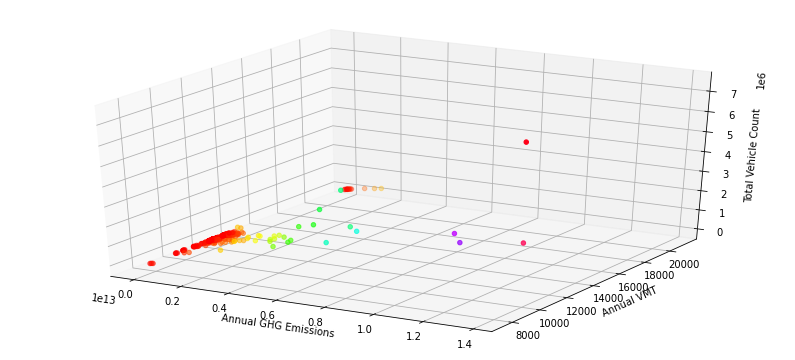

In [64]:
fig1=plt.figure(figsize=(14,14))
ax1 = fig1.add_subplot(211,projection='3d')
zdata = model['total_vehicle_count']
xdata = model['annual_ghg_emissions']
ydata = model['annual_vmt']
ax1.scatter3D(xdata, ydata, zdata, c=xdata, cmap='hsv');
ax1.set_ylabel('Annual VMT')
ax1.set_xlabel('Annual GHG Emissions')
ax1.set_zlabel('Total Vehicle Count')

Text(0.5, 0, 'Total Vehicle Count')

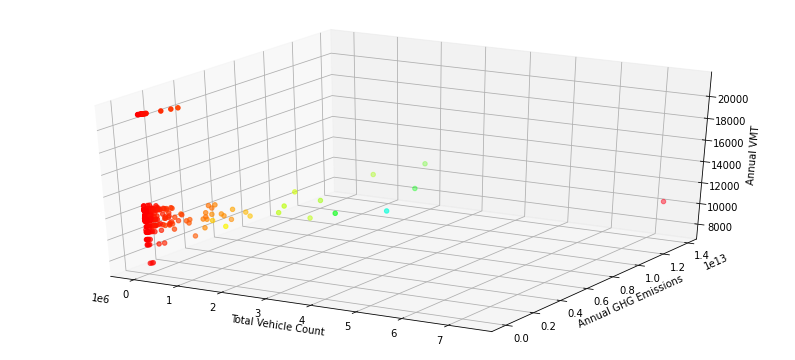

In [65]:
fig2=plt.figure(figsize=(14,14))
ax2 = fig2.add_subplot(211,projection='3d')
xdata = model['total_vehicle_count']
ydata = model['annual_ghg_emissions']
zdata = model['annual_vmt']
ax2.scatter3D(xdata, ydata, zdata, c=xdata, cmap='hsv');
ax2.set_zlabel('Annual VMT')
ax2.set_ylabel('Annual GHG Emissions')
ax2.set_xlabel('Total Vehicle Count')

Text(0.5, 0, 'Total Vehicle Count')

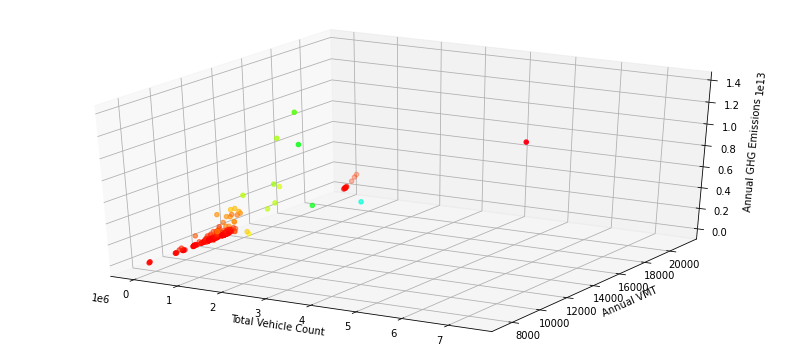

In [66]:
fig3=plt.figure(figsize=(14,14))
ax3 = fig3.add_subplot(211,projection='3d')
xdata = model['total_vehicle_count']
zdata = model['annual_ghg_emissions']
ydata = model['annual_vmt']
ax3.scatter3D(xdata, ydata, zdata, c=xdata, cmap='hsv');
ax3.set_ylabel('Annual VMT')
ax3.set_zlabel('Annual GHG Emissions')
ax3.set_xlabel('Total Vehicle Count')
# ax3.view_init(0,25)

In [67]:
# fig3=plt.figure(figsize=(14,14))
# ax3 = fig3.add_subplot(211,projection='3d')
# zdata = model['total_vehicle_count']
# ydata = model['annual_ghg_emissions']
# xdata = model['annual_vmt']
# # ax3.scatter3D(xdata, ydata, zdata, c=xdata, cmap='hsv');
# # ax.contour3D(xdata, ydata, zdata, 50, cmap='binary')
# ax3.set_xlabel('Annual VMT')
# ax3.set_ylabel('Annual GHG Emissions')
# ax3.set_zlabel('Total Vehicle Count')

#### [Contour 3D Plot](https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html)
Attempts to make a 3D contour plot were unsuccessful because this requires that the zdata to actually have 2 dimensions, and to be a function of x and y. In other words, currently, it is just a single axis, unrelated to x and y. In short, z needs to be a grid array. This is possible, but requires additional troubleshooting, probably using the [Interpolate Data function from SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html).

#### Limitations with 3D Plotting

3D plots are most useful when your X, Y and Z values are all continuous variables. For this reason, including state in the diagram is not possible / not useful for analysis. It is also difficult to align the view well, so adjustment might be required. Once a view is chosen from the above selection, delivering the rest of the raw graphs for each of the 3 states will be trivial.

#### Future Works
The first thing that comes to mind is figuring out a budget to pay for the EC2 uptime -- and finally being a part of a paper that enters the 21st century in augmenting the static written paper with a user-friendly portal to actually explore the data. It will probably cost $20 to have the system up all year, depending on traffic. 

ssh -i buddy_biofuels.pem ec2-user@ec2-54-202-254-8.us-west-2.compute.amazonaws.com

In [69]:
model.head(10)

County State  annual_ghg_emissions  annual_operating_cost  \
0        Alameda    CA      1783929600000.00           318966620.00   
1   Contra Costa    CA      4027894200000.00           240519220.00   
2  San Francisco    CA      1565396800000.00           119103380.00   
3      San Mateo    CA      3143350500000.00           187700110.00   
4         Alpine    CA         3585886300.00             1133274.62   
5         Amador    CA        71470663000.00            15703854.50   
6      Calaveras    CA        98361826000.00            36755748.00   
7         Lassen    CA        25027358900.00            10962502.54   
8       Mariposa    CA        43932691000.00            11913482.10   
9         Plumas    CA        25952409400.00            10058090.19   

   total_annual_cost  annual_fuel_use  total_vehicle_count  vehicle_split_BEV  \
0      7192956300.00     136290200.00           1217269.00         1217269.00   
1      5423903700.00     102770660.00            917891.00          917891.00   
2      2685878000.00      50891291.00            454533.00          454533.00   
3      4232790000.00      80201763.00            716318.00          716318.00   
4        12695918.30        420333.98              1821.00             396.96   
5       198967876.00       5947661.70             29750.00           12759.69   
6       392792573.00      13531418.26             55341.00            6895.82   
7       112205048.40       4009361.11             15536.00             498.27   
8       136152784.00       4433092.46             19670.00            5019.83   
9       106466700.20       3697381.55             14944.00            1565.75   

   vehicle_split_FFV  vehicle_split_SIDI  vehicle_pc_BEV  vehicle_pc_FFV  \
0               0.00                0.00          100.00            0.00   
1               0.00                0.00          100.00            0.00   
2               0.00                0.00          100.00            0.00   
3               0.00                0.00          100.00            0.00   
4               0.00             1424.04           21.80            0.00   
5               0.00            16990.31           42.90            0.00   
6               0.00            48445.18           12.50            0.00   
7               0.00            15037.73            3.20            0.00   
8               0.00            14650.17           25.50            0.00   
9               0.00            13378.25           10.50            0.00   

   vehicle_pc_SIDI  efuels_area  census_area  census_totpop  census_urbpop  \
0             0.00       100.00       739.02        1510271        1504402   
1             0.00       100.00       715.94        1049025        1040709   
2             0.00       100.00        46.87         805235         805235   
3             0.00       100.00       448.41         718451         704865   
4            78.20        21.80       738.33           1175              0   
5            57.10        42.89       594.58          38091          15075   
6            87.50        12.46      1020.01          45578          11208   
7            96.80         3.21      4541.18          34895          10285   
8            74.50        25.52      1448.82          18251              0   
9            89.50        10.48      2553.04          20007           5197   

   census_rurpop  pct_rural  pop_density county_class  ghg_globalrank  \
0           5869       0.40      2043.62        urban           28.00   
1           8316       0.80      1465.25        urban           13.00   
2              0       0.00     17179.08        urban           33.00   
3          13586       1.90      1602.23        urban           16.00   
4           1175     100.00         1.59        rural          393.00   
5          23016      60.40        64.06        rural          234.00   
6          34370      75.40        44.68        rural          199.00   
7          24610      70.50         7.68        rural   

number of vehicles (meaning automobiles) in the united states: https://www.statista.com/statistics/196072/number-of-registered-automobiles-in-texas/


find out annual GHG emissions due to vehicles from each state. Find this out using a combination of knowing the number of vehicles in each type in that state and multiplying by fuel GHG factor.
then, find the differential between carbon emissions (2017 optimised versus 2017 not-optimised).

##### 01/18/2021 Additional Future Works Ideas

I also suggest the following:
- Expanding the remit of this project beyond CA, TX, MN to the rest of the United States
- Creating a recommender engine that discerns where viable growth is to better understand where to put new stations. 
    - (maybe looking at market trend data for consumer purchasing decisions), fuel pump data
- Fuel pump data can also be used to understand the bottom-up figures for carbon emissions. 
- Expand to trucking and other forms of transport outside of automotive.